In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [12]:
img_mean = (123.675, 116.28, 103.53)
# img_std = (58.395, 57.12, 57.375)
img_std = (1., 1., 1.)

In [73]:
train_dataset = CocoDataSet('./', 'train',
                                 flip_ratio=0.0,
                                 pad_mode='fixed',
                                 mean=img_mean,
                                 std=img_std,
                                 scale=(416, 416))

test_dataset = CocoDataSet('./', 'test',
                                 flip_ratio=0.0,
                                 pad_mode='fixed',
                                 mean=img_mean,
                                 std=img_std,
                                 scale=(416, 416))

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [23]:
cat = train_dataset.get_categories()

In [74]:
# prepare test dataset for yolo
savetopath = "/Users/home/Documents/Research/repos/TensorFlow-2.x-YOLOv3/dataset/LEs/LEs_test/"
with open("/Users/home/Documents/Research/repos/TensorFlow-2.x-YOLOv3/dataset/LEs/LEs_test.txt", 'w') as f:

    for image_num in range( len(test_dataset) ):
        print(image_num)
        img, img_meta, bboxes, labels = test_dataset[image_num]
        rgb_img = np.round(img + img_mean)
        
        image_ann = os.path.join(savetopath, "%06d.jpg" %(image_num+1))
        
        cv2.imwrite(image_ann, rgb_img)
        for i in range( len(bboxes)):
            y1, x1, y2, x2 = bboxes[i]
            y1, x1, y2, x2 = int(y1), int(x1), int(y2), int(x2)
            xmin = str(x1)
            ymin = str(y1)
            xmax = str(x2)
            ymax = str(y2)
            class_ind = str(labels[i]-2)
            image_ann += ' ' + ','.join([xmin, ymin, xmax, ymax, str(class_ind)])
        f.write(image_ann + "\n")
     

0
.//test2017/159.jpg
1
.//test2017/102.jpg
2
.//test2017/47.jpg
3
.//test2017/88.jpg
4
.//test2017/168.jpg
5
.//test2017/127.jpg
6
.//test2017/53.jpg
7
.//test2017/59.jpg
8
.//test2017/137.jpg
9
.//test2017/54.jpg
10
.//test2017/19.jpg


In [75]:
# prepare train dataset for yolo
savetopath = "/Users/home/Documents/Research/repos/TensorFlow-2.x-YOLOv3/dataset/LEs/LEs_train/"
with open("/Users/home/Documents/Research/repos/TensorFlow-2.x-YOLOv3/dataset/LEs/LEs_train.txt", 'w') as f:

    for image_num in range( len(train_dataset) ):
        print(image_num)
        img, img_meta, bboxes, labels = train_dataset[image_num]
        rgb_img = np.round(img + img_mean)
        
        image_ann = os.path.join(savetopath, "%06d.jpg" %(image_num+1))
        
        cv2.imwrite(image_ann, rgb_img)
        for i in range( len(bboxes)):
            y1, x1, y2, x2 = bboxes[i]
            y1, x1, y2, x2 = int(y1), int(x1), int(y2), int(x2)
            xmin = str(x1)
            ymin = str(y1)
            xmax = str(x2)
            ymax = str(y2)
            class_ind = str(labels[i]-2)
            image_ann += ' ' + ','.join([xmin, ymin, xmax, ymax, str(class_ind)])
        f.write(image_ann + "\n")


0
.//train2017/103.jpg
1
.//train2017/40.jpg
2
.//train2017/46.jpg
3
.//train2017/28.jpg
4
.//train2017/170.jpg
5
.//train2017/52.jpg
6
.//train2017/126.jpg
7
.//train2017/167.jpg
8
.//train2017/18.jpg
9
.//train2017/160.jpg
10
.//train2017/136.jpg
11
.//train2017/157.jpg


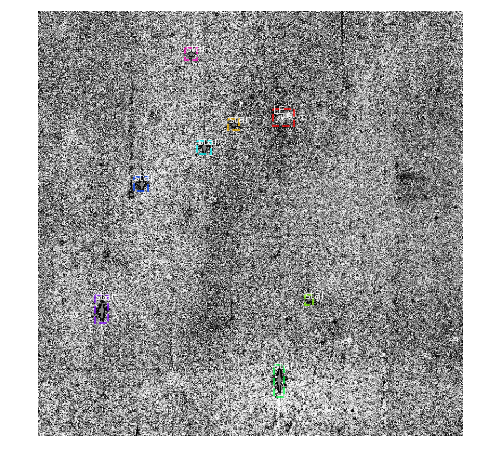

In [28]:
display_instances(image=rgb_img, boxes=bboxes, 
                  class_ids=labels, class_names=cat, figsize=(8,8))

### visualize

In [15]:
import os
import sys
import random
import itertools
import colorsys

import numpy as np
from skimage.measure import find_contours

import matplotlib.pyplot as plt
from matplotlib import patches, lines
from matplotlib.patches import Polygon
# import IPython.display

def random_colors(N, bright=True):
    '''
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    '''
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def display_instances(image, boxes, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None):
    '''
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    figsize: (optional) the size of the image.
    '''
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    # else:
    #     assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)

    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        y1, x1, y2, x2 = int(y1), int(x1), int(y2), int(x2)
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
        ax.add_patch(p)

        # Label
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        label = class_names[class_id]
        x = random.randint(x1, (x1 + x2) // 2)
        caption = "{} {:.3f}".format(label, score) if score else label
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")


    plt.imshow(image.astype(np.uint8))
    
def draw_boxes(image, boxes=None, refined_boxes=None,
               captions=None, visibilities=None,
               title="", ax=None):
    '''Draw bounding boxes and segmentation masks with differnt
    customizations.
    boxes: [N, (y1, x1, y2, x2, class_id)] in image coordinates.
    refined_boxes: Like boxes, but draw with solid lines to show
        that they're the result of refining 'boxes'.
    captions: List of N titles to display on each box
    visibilities: (optional) List of values of 0, 1, or 2. Determine how
        prominant each bounding box should be.
    title: An optional title to show over the image
    ax: (optional) Matplotlib axis to draw on.
    '''
    # Number of boxes
    N = boxes.shape[0] if boxes is not None else refined_boxes.shape[0]

    # Matplotlib Axis
    if not ax:
        _, ax = plt.subplots(1, figsize=(16, 16))

    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    margin = image.shape[0] // 10
    ax.set_ylim(image.shape[0] + margin, -margin)
    ax.set_xlim(-margin, image.shape[1] + margin)
    ax.axis('off')

    ax.set_title(title)

    for i in range(N):
        # Box visibility
        visibility = visibilities[i] if visibilities is not None else 1
        if visibility == 0:
            color = "gray"
            style = "dotted"
            alpha = 0.5
        elif visibility == 1:
            color = colors[i]
            style = "dotted"
            alpha = 1
        elif visibility == 2:
            color = colors[i]
            style = "solid"
            alpha = 1

        # Boxes
        if boxes is not None:
            if not np.any(boxes[i]):
                # Skip this instance. Has no bbox. Likely lost in cropping.
                continue
            y1, x1, y2, x2 = boxes[i]
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                  alpha=alpha, linestyle=style,
                                  edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Refined boxes
        if refined_boxes is not None and visibility > 0:
            ry1, rx1, ry2, rx2 = refined_boxes[i].astype(np.int32)
            p = patches.Rectangle((rx1, ry1), rx2 - rx1, ry2 - ry1, linewidth=2,
                                  edgecolor=color, facecolor='none')
            ax.add_patch(p)
            # Connect the top-left corners of the anchor and proposal
            if boxes is not None:
                ax.add_line(lines.Line2D([x1, rx1], [y1, ry1], color=color))

        # Captions
        if captions is not None:
            caption = captions[i]
            # If there are refined boxes, display captions on them
            if refined_boxes is not None:
                y1, x1, y2, x2 = ry1, rx1, ry2, rx2
            x = random.randint(x1, (x1 + x2) // 2)
            ax.text(x1, y1, caption, size=11, verticalalignment='top',
                    color='w', backgroundcolor="none",
                    bbox={'facecolor': color, 'alpha': 0.5,
                          'pad': 2, 'edgecolor': 'none'})

    ax.imshow(image.astype(np.uint8))

### CocoDataSet

In [18]:
import os.path as osp
import cv2
import numpy as np
from pycocotools.coco import COCO

from detection.datasets import transforms, utils

class CocoDataSet(object):
    def __init__(self, dataset_dir, subset,
                 flip_ratio=0,
                 pad_mode='fixed',
                 mean=(0, 0, 0),
                 std=(1, 1, 1),
                 scale=(1024, 800),
                 debug=False):
        '''Load a subset of the COCO dataset.
        
        Attributes
        ---
            dataset_dir: The root directory of the COCO dataset.
            subset: What to load (train, val).
            flip_ratio: Float. The ratio of flipping an image and its bounding boxes.
            pad_mode: Which padded method to use (fixed, non-fixed)
            mean: Tuple. Image mean.
            std: Tuple. Image standard deviation.
            scale: Tuple of two integers.
        '''
        
        if subset not in ['train', 'val', 'test']:
            raise AssertionError('subset must be "train", "val", "test"') 
            

        self.coco = COCO("{}/annotations/instances_{}2017.json".format(dataset_dir, subset))

        # get the mapping from original category ids to labels
        self.cat_ids = self.coco.getCatIds()
        self.cat2label = {
            cat_id: i + 1
            for i, cat_id in enumerate(self.cat_ids)
        }
        
        self.img_ids, self.img_infos = self._filter_imgs()
        
        if debug:
            self.img_ids, self.img_infos = self.img_ids[:50], self.img_infos[:50]
            
        self.image_dir = "{}/{}2017".format(dataset_dir, subset)
        
        self.flip_ratio = flip_ratio
        
        if pad_mode in ['fixed', 'non-fixed']:
            self.pad_mode = pad_mode
        elif subset == 'train':
            self.pad_mode = 'fixed'
        else:
            self.pad_mode = 'non-fixed'
        
        self.img_transform = transforms.ImageTransform(scale, mean, std, pad_mode)
        self.bbox_transform = transforms.BboxTransform()
        
        
    def _filter_imgs(self, min_size=32):
        '''Filter images too small or without ground truths.
        
        Args
        ---
            min_size: the minimal size of the image.
        '''
        # Filter images without ground truths.
        all_img_ids = list(set([_['image_id'] for _ in self.coco.anns.values()]))
        # Filter images too small.
        img_ids = []
        img_infos = []
        for i in all_img_ids:
            info = self.coco.loadImgs(i)[0]
            
            ann_ids = self.coco.getAnnIds(imgIds=i)
            ann_info = self.coco.loadAnns(ann_ids)
            ann = self._parse_ann_info(ann_info)
            
            if min(info['width'], info['height']) >= min_size and ann['labels'].shape[0] != 0:
                img_ids.append(i)
                img_infos.append(info)
        return img_ids, img_infos
        
    def _load_ann_info(self, idx):
        img_id = self.img_ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        ann_info = self.coco.loadAnns(ann_ids)
        return ann_info

    def _parse_ann_info(self, ann_info):
        '''Parse bbox annotation.
        
        Args
        ---
            ann_info (list[dict]): Annotation info of an image.
            
        Returns
        ---
            dict: A dict containing the following keys: bboxes, 
                bboxes_ignore, labels.
        '''
        gt_bboxes = []
        gt_labels = []
        gt_bboxes_ignore = []

        for i, ann in enumerate(ann_info):
            if ann.get('ignore', False):
                continue
            x1, y1, w, h = ann['bbox']
            if ann['area'] <= 0 or w < 1 or h < 1:
                continue
            bbox = [y1, x1, y1 + h - 1, x1 + w - 1]
            if ann['iscrowd']:
                gt_bboxes_ignore.append(bbox)
            else:
                gt_bboxes.append(bbox)
                gt_labels.append(self.cat2label[ann['category_id']])

        if gt_bboxes:
            gt_bboxes = np.array(gt_bboxes, dtype=np.float32)
            gt_labels = np.array(gt_labels, dtype=np.int64)
        else:
            gt_bboxes = np.zeros((0, 4), dtype=np.float32)
            gt_labels = np.array([], dtype=np.int64)

        if gt_bboxes_ignore:
            gt_bboxes_ignore = np.array(gt_bboxes_ignore, dtype=np.float32)
        else:
            gt_bboxes_ignore = np.zeros((0, 4), dtype=np.float32)

        ann = dict(
            bboxes=gt_bboxes, labels=gt_labels, bboxes_ignore=gt_bboxes_ignore)


        return ann
    
    def __len__(self):
        return len(self.img_infos)
    
    def __getitem__(self, idx):
        '''Load the image and its bboxes for the given index.
        
        Args
        ---
            idx: the index of images.
            
        Returns
        ---
            tuple: A tuple containing the following items: image, 
                bboxes, labels.
        '''
        img_info = self.img_infos[idx]
        ann_info = self._load_ann_info(idx)
        
        # load the image.
        imgpath = osp.join(self.image_dir, img_info['file_name'])
        img = cv2.imread(imgpath, cv2.IMREAD_COLOR)
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        print(imgpath)
        
        ori_shape = img.shape
        
        # Load the annotation.
        ann = self._parse_ann_info(ann_info)
        bboxes = ann['bboxes']
        labels = ann['labels']
        
        flip = True if np.random.rand() < self.flip_ratio else False
        
        # Handle the image
        img, img_shape, scale_factor = self.img_transform(img, flip)

        pad_shape = img.shape
        
        # Handle the annotation.
        bboxes, labels = self.bbox_transform(
            bboxes, labels, img_shape, scale_factor, flip)
        
        # Handle the meta info.
        img_meta_dict = dict({
            'ori_shape': ori_shape,
            'img_shape': img_shape,
            'pad_shape': pad_shape,
            'scale_factor': scale_factor,
            'flip': flip
        })

        img_meta = utils.compose_image_meta(img_meta_dict)
        
        return img, img_meta, bboxes, labels
    
    def get_categories(self):
        '''Get list of category names. 
        
        Returns
        ---
            list: A list of category names.
            
        Note that the first item 'bg' means background.
        '''
        return ['bg'] + [self.coco.loadCats(i)[0]["name"] for i in self.cat2label.keys()]

